<a href="https://colab.research.google.com/github/Nageswar-Sahoo/Computer-Vision-Project/blob/main/S10/AssignmentPart2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
ls  


gdrive/MyDrive/sample_coco.txt


In [82]:
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
from matplotlib.patches import Rectangle
%matplotlib inline

In [6]:
import pandas as pd
colnames = ['Class_ID', 'IMG_HT', 'IMG_WD', 'BBOX_Y1', 'BBOX_X1', 'BBOX_Y2', 'BBOX_X2', 'Blank']
coco_df = pd.read_csv("gdrive/MyDrive/sample_coco.txt", names= colnames)
coco_df = coco_df.drop(['Blank'], axis = 1)
coco_df['Class_ID'] = coco_df['Class_ID'].str[4:]
coco_df['IMG_HT'] = coco_df['IMG_HT'].str[9:]
coco_df['IMG_WD'] = coco_df['IMG_WD'].str[8:]
coco_df['BBOX_Y1'] = coco_df['BBOX_Y1'].str[7:]
coco_df['BBOX_X2'] = coco_df['BBOX_X2'].str[1:-1]
coco_df["Class_ID"] = pd.to_numeric(coco_df["Class_ID"])
coco_df = coco_df.sort_values(["Class_ID"])

coco_df.head(3)

,Class_ID,IMG_HT,IMG_WD,BBOX_Y1,BBOX_X1,BBOX_Y2,BBOX_X2
0,0,330,1093,69,464,312,175
1026,0,763,821,498,471,252,116
6245,0,669,304,25,24,85,346


In [8]:
coco_df['BBOX_HT'] = abs(pd.to_numeric(coco_df['BBOX_Y1']) - pd.to_numeric(coco_df['BBOX_Y2']))/ abs(pd.to_numeric(coco_df['IMG_HT']))
coco_df['BBOX_WT'] = abs(pd.to_numeric(coco_df['BBOX_X1']) - pd.to_numeric(coco_df['BBOX_X2']))/abs(pd.to_numeric(coco_df['IMG_WD']))
coco_df.head(3)

,Class_ID,IMG_HT,IMG_WD,BBOX_Y1,BBOX_X1,BBOX_Y2,BBOX_X2,BBOX_HT,BBOX_WT
0,0,330,1093,69,464,312,175,0.736364,0.264410
1026,0,763,821,498,471,252,116,0.322412,0.432400
6245,0,669,304,25,24,85,346,0.089686,1.059211


In [67]:
coco_df['BBOX_HT'] = abs(pd.to_numeric(coco_df['BBOX_Y1']) - pd.to_numeric(coco_df['BBOX_Y2']))
coco_df['BBOX_WT'] = abs(pd.to_numeric(coco_df['BBOX_X1']) - pd.to_numeric(coco_df['BBOX_X2']))
coco_df.head(3)

,Class_ID,IMG_HT,IMG_WD,BBOX_Y1,BBOX_X1,BBOX_Y2,BBOX_X2,BBOX_HT,BBOX_WT
0,0,330,1093,69,464,312,175,243,289
1026,0,763,821,498,471,252,116,246,355
6245,0,669,304,25,24,85,346,60,322


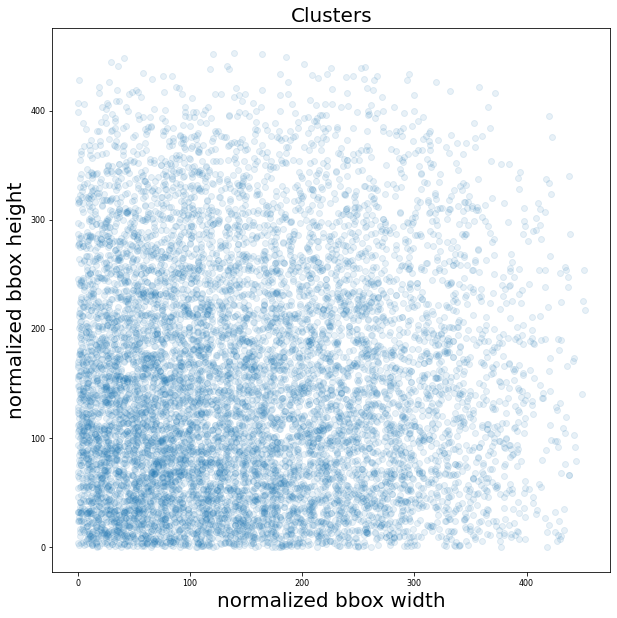

In [68]:
plt.figure(figsize=(10,10))
plt.scatter(coco_df['BBOX_HT'],coco_df['BBOX_WT'],alpha=0.1)
plt.title("Clusters",fontsize=20)
plt.xlabel("normalized bbox width",fontsize=20)
plt.ylabel("normalized bbox height",fontsize=20)
plt.show()

In [13]:
def iou(box, clusters):
    '''
    :param box:      np.array of shape (2,) containing w and h
    :param clusters: np.array of shape (N cluster, 2) 
    '''
    x = np.minimum(clusters[:, 0], box[0]) 
    y = np.minimum(clusters[:, 1], box[1])

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_

In [14]:
def kmeans(boxes, k, dist=np.median,seed=1):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances     = np.empty((rows, k)) ## N row x N cluster
    last_clusters = np.zeros((rows,))

    np.random.seed(seed)

    # initialize the cluster centers to be k items
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        # Step 1: allocate each item to the closest cluster centers
        for icluster in range(k): # I made change to lars76's code here to make the code faster
            distances[:,icluster] = 1 - iou(clusters[icluster], boxes)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break
            
        # Step 2: calculate the cluster centers as mean (or median) of all the cases in the clusters.
        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters,nearest_clusters,distances

array([[0.26440988, 0.73636364],
       [0.43239951, 0.32241153],
       [1.05921053, 0.0896861 ],
       ...,
       [0.22910521, 0.25025536],
       [0.06952663, 0.46121884],
       [0.07361963, 0.18173432]])

In [97]:
kmax = 8
dist = np.mean
results = {}
wh=coco_df[['BBOX_WT','BBOX_HT']].to_numpy()
for k in range(2,kmax):
    clusters, nearest_clusters, distances = kmeans(wh,k,seed=2,dist=dist)
    WithinClusterMeanDist = np.mean(distances[np.arange(distances.shape[0]),nearest_clusters])
    result = {"clusters":             clusters,
              "nearest_clusters":     nearest_clusters,
              "distances":            distances,
              "WithinClusterMeanDist": WithinClusterMeanDist}
    print("{:2.0f} clusters: mean IoU = {:5.4f}".format(k,1-result["WithinClusterMeanDist"]))
    results[k] = result

 2 clusters: mean IoU = 0.4091
 3 clusters: mean IoU = 0.4639
 4 clusters: mean IoU = 0.5003
 5 clusters: mean IoU = 0.5313
 6 clusters: mean IoU = 0.5509
 7 clusters: mean IoU = 0.5684


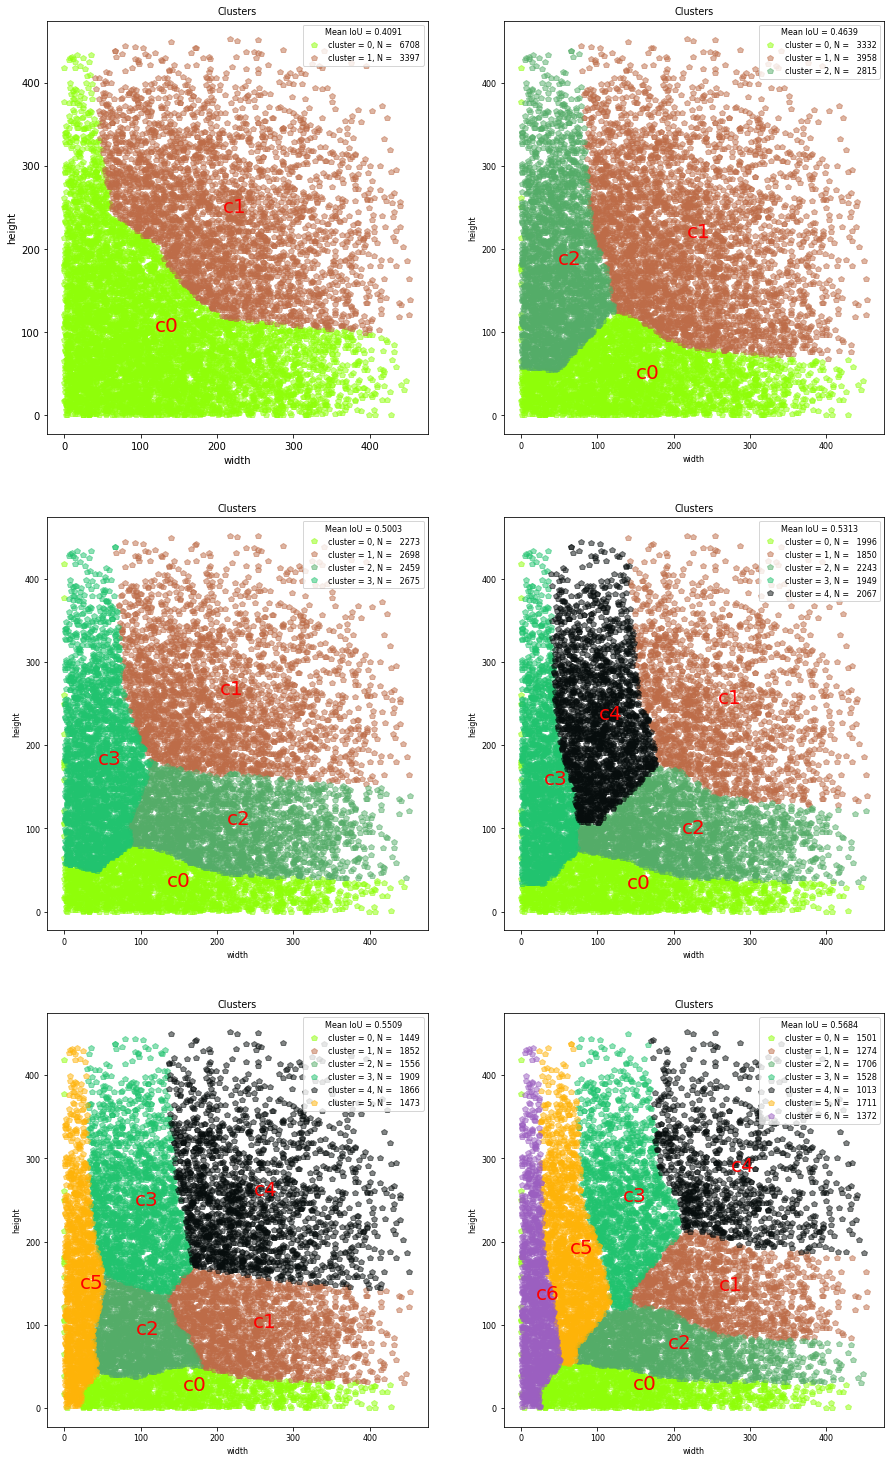

In [98]:
def plot_cluster_result(plt,clusters,nearest_clusters,WithinClusterSumDist,wh):
    for icluster in np.unique(nearest_clusters):
        pick = nearest_clusters==icluster
        c = current_palette[icluster]
        plt.rc('font', size=8) 
        plt.plot(wh[pick,0],wh[pick,1],"p",
                 color=c,
                 alpha=0.5,label="cluster = {}, N = {:6.0f}".format(icluster,np.sum(pick)))
        plt.text(clusters[icluster,0],
                 clusters[icluster,1],
                 "c{}".format(icluster),
                 fontsize=20,color="red")
        plt.title("Clusters")
        plt.xlabel("width")
        plt.ylabel("height")
    plt.legend(title="Mean IoU = {:5.4f}".format(WithinClusterSumDist))  
    
import seaborn as sns
current_palette = list(sns.xkcd_rgb.values())

figsize = (15,35)
count =1 
fig = plt.figure(figsize=figsize)
for k in range(2,kmax):
    result               = results[k]
    clusters             = result["clusters"]
    nearest_clusters     = result["nearest_clusters"]
    WithinClusterSumDist = result["WithinClusterMeanDist"]
    
    ax = fig.add_subplot(kmax/2,2,count)
    plot_cluster_result(plt,clusters,nearest_clusters,1 - WithinClusterSumDist,wh)
    count += 1
plt.show()

In [99]:
Nanchor_box = 2
results[Nanchor_box]["clusters"]

array([[118, 101],
       [208, 244]], dtype=int64)

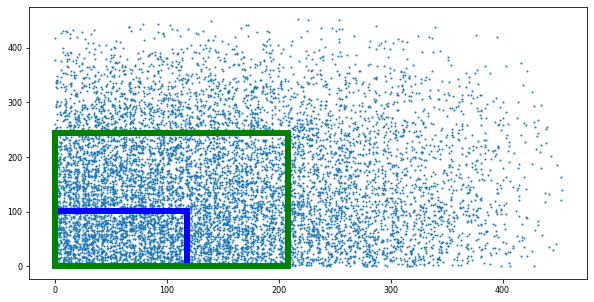

In [100]:
matplotlib.rc('figure', figsize=(10, 5))
  
# highlight some feature in the
# middle boxes.
fig = plt.figure()
color=['b','g','r','c','m','y','k']  
ax = fig.add_subplot(111)

plt.scatter(coco_df['BBOX_WT'],coco_df['BBOX_HT'],s=1)
for i in range (2):

  ax.add_patch ( Rectangle(  (0, 0),
                        results[Nanchor_box]["clusters"][i][0], results[Nanchor_box]["clusters"][i][1],
                        fc='none',
                        ec =color[i],
                        linewidth = 6
                        ) )
  
plt.show()

In [101]:
Nanchor_box = 3
results[Nanchor_box]["clusters"]

array([[150,  45],
       [218, 214],
       [ 48, 181]], dtype=int64)

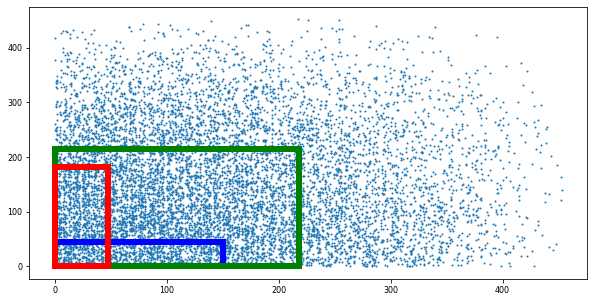

In [102]:
matplotlib.rc('figure', figsize=(10, 5))
  
# highlight some feature in the
# middle boxes.
fig = plt.figure()
color=['b','g','r','c','m','y','k']  
ax = fig.add_subplot(111)

plt.scatter(coco_df['BBOX_WT'],coco_df['BBOX_HT'],s=1)
for i in range (3):

  ax.add_patch ( Rectangle(  (0, 0),
                        results[Nanchor_box]["clusters"][i][0], results[Nanchor_box]["clusters"][i][1],
                        fc='none',
                        ec =color[i],
                        linewidth = 6
                        ) )
  
plt.show()

In [103]:
Nanchor_box = 4
results[Nanchor_box]["clusters"]

array([[134,  31],
       [204, 261],
       [213, 105],
       [ 44, 177]], dtype=int64)

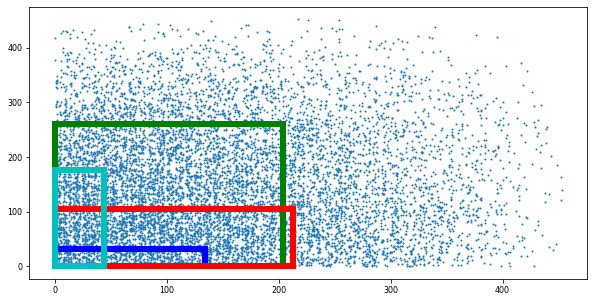

In [104]:
matplotlib.rc('figure', figsize=(10, 5))
  
# highlight some feature in the
# middle boxes.
fig = plt.figure()
color=['b','g','r','c','m','y','k']  
ax = fig.add_subplot(111)

plt.scatter(coco_df['BBOX_WT'],coco_df['BBOX_HT'],s=1)
for i in range (4):

  ax.add_patch ( Rectangle(  (0, 0),
                        results[Nanchor_box]["clusters"][i][0], results[Nanchor_box]["clusters"][i][1],
                        fc='none',
                        ec =color[i],
                        linewidth = 6
                        ) )
  
plt.show()

In [105]:
Nanchor_box = 5
results[Nanchor_box]["clusters"]

array([[139,  28],
       [258, 250],
       [211,  94],
       [ 30, 153],
       [102, 231]], dtype=int64)

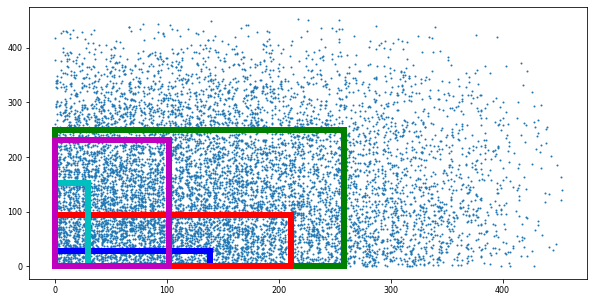

In [106]:
matplotlib.rc('figure', figsize=(10, 5))
  
# highlight some feature in the
# middle boxes.
fig = plt.figure()
color=['b','g','r','c','m','y','k']  
ax = fig.add_subplot(111)

plt.scatter(coco_df['BBOX_WT'],coco_df['BBOX_HT'],s=1)
for i in range (5):

  ax.add_patch ( Rectangle(  (0, 0),
                        results[Nanchor_box]["clusters"][i][0], results[Nanchor_box]["clusters"][i][1],
                        fc='none',
                        ec =color[i],
                        linewidth = 6
                        ) )
  
plt.show()

In [107]:
Nanchor_box = 6
results[Nanchor_box]["clusters"]

array([[155,  21],
       [247,  97],
       [ 94,  88],
       [ 93, 244],
       [248, 256],
       [ 20, 144]], dtype=int64)

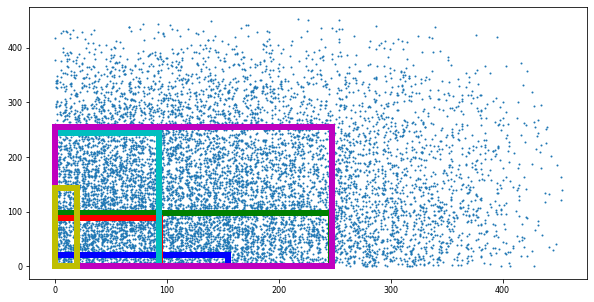

In [108]:
matplotlib.rc('figure', figsize=(10, 5))
  
# highlight some feature in the
# middle boxes.
fig = plt.figure()
color=['b','g','r','c','m','y','k']  
ax = fig.add_subplot(111)

plt.scatter(coco_df['BBOX_WT'],coco_df['BBOX_HT'],s=1)
for i in range (6):

  ax.add_patch ( Rectangle(  (0, 0),
                        results[Nanchor_box]["clusters"][i][0], results[Nanchor_box]["clusters"][i][1],
                        fc='none',
                        ec =color[i],
                        linewidth = 6
                        ) )
  
plt.show()

In [109]:
Nanchor_box = 7
results[Nanchor_box]["clusters"]

array([[147,  23],
       [259, 142],
       [192,  72],
       [134, 249],
       [275, 284],
       [ 64, 186],
       [ 19, 131]], dtype=int64)

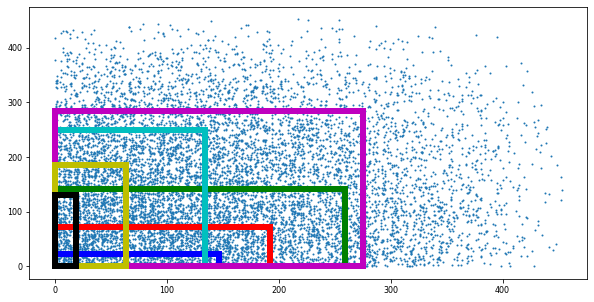

In [110]:
matplotlib.rc('figure', figsize=(10, 5))
  
# highlight some feature in the
# middle boxes.
fig = plt.figure()
color=['b','g','r','c','m','y','k']  
ax = fig.add_subplot(111)

plt.scatter(coco_df['BBOX_WT'],coco_df['BBOX_HT'],s=1)
for i in range (7):

  ax.add_patch ( Rectangle(  (0, 0),
                        results[Nanchor_box]["clusters"][i][0], results[Nanchor_box]["clusters"][i][1],
                        fc='none',
                        ec =color[i],
                        linewidth = 6
                        ) )
  
plt.show()